# **Online Retail Transactions - ETL**

## Objectives

* This notebook prepare online retail transaction data to perfrom analysis on customer behavior, identify popular products, and optimize business strategies. 

## Inputs

*  [Online Retail Transactions Dataset from Kaggle](https://www.kaggle.com/datasets/abhishekrp1517/online-retail-transactions-dataset) 

## Outputs

* Cleaned and transformed data



We eant to Load the data from the original data set reside within data directory

In [1]:
import os
import numpy as np
import pandas as pd

# Data directory paths
data_path = os.path.join("..", "data")

df_original = pd.read_csv(os.path.join(data_path, "online_retail.csv"))
print(f"Original dataset shape: {df_original.shape}")

Original dataset shape: (541909, 8)


We need to have the initial look at the data set in nhigh level

In [ ]:
# Quick Look 
print("=== Frist 4 rows ===")
with pd.option_context('display.max_columns', None):
    print(df_original.head())

# How many rows and columns
print("=== How many rows and columns ===")
print(df_original.shape)

# What are the column name
print("=== What are the column name ===")
print(df_original.columns)

# Data counts 
print("=== Data counts ===")
print(df_original.info())

# NA counts
print("=== Is there any nulls ===")
print(df_original.isna().sum())

# Duplicate counts
print("=== Is there any duplicated rows ===")
print(df_original.duplicated().sum())

# Basic stats for numeric columns
print("=== Basic stats for numeric columns ===")
print(df_original.describe())

We need to furhter analyse the data set as the Initial look shows that
*  There are minus values in quantity and unit price
*  There are extreme outliers 

In [ ]:
# Explore negative quantities and prices

print("\nNumber of invoices with Quantity and UnitPrice > 0 :")
dfnqu = df_original[(df_original['Quantity'] < 0) | (df_original['UnitPrice'] < 0)]
with pd.option_context('display.max_columns', None, 'display.width', 1000):
    print(dfnqu.head())
print(dfnqu['InvoiceNo'].nunique())
print("\nShape of the Data Set:")
print(dfnqu.shape)

# Explore Invoices with the code C
print("\nNumber of negative invoices:")
dfc = df_original[df_original['InvoiceNo'].astype(str).str.startswith('C')]
with pd.option_context('display.max_columns', None, 'display.width', 1000):
    print(dfc.head())
print(dfc['InvoiceNo'].nunique())

print("\nShape of the Data Set:")
print(dfc.shape)

C:\Users\Hp 2022\AppData\Local\Temp\ipykernel_23148\133924931.py:26: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(data=df_original[['Quantity', 'UnitPrice']], ax=axes[2], palette=theme_colors[:3])


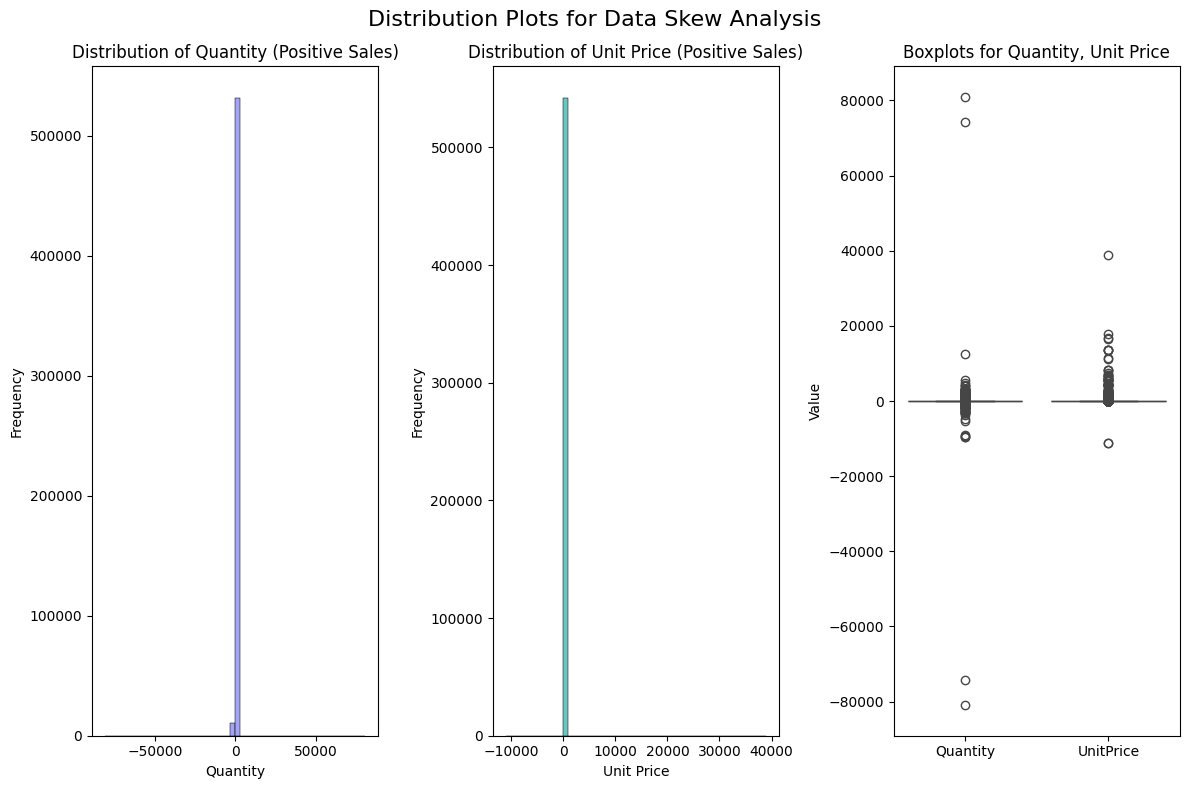

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create distribution plots to identify data skews
figsize = (12, 8)
theme_colors = ['#8686F2', '#38B3AA', '#E85573', '#E59F55', '#E67642', '#5778D3']

# Subplots for distributions
fig, axes = plt.subplots(1, 3, figsize=figsize)
fig.suptitle('Distribution Plots for Data Skew Analysis', fontsize=16)

# Quantity distribution (positive only for sales)
sns.histplot(df_original['Quantity'], bins=50, ax=axes[0], color=theme_colors[0])
axes[0].set_title('Distribution of Quantity (Positive Sales)')
axes[0].set_xlabel('Quantity')
axes[0].set_ylabel('Frequency')

# UnitPrice distribution (positive)
sns.histplot(df_original['UnitPrice'], bins=50, ax=axes[1], color=theme_colors[1])
axes[1].set_title('Distribution of Unit Price (Positive Sales)')
axes[1].set_xlabel('Unit Price')
axes[1].set_ylabel('Frequency')


# Boxplot for Quantity, UnitPrice, Revenue
sns.boxplot(data=df_original[['Quantity', 'UnitPrice']], ax=axes[2], palette=theme_colors[:3])
axes[2].set_title('Boxplots for Quantity, Unit Price')
axes[2].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [59]:
#Simple analysis to understand outlier causes
print("=== OUTLIER INVESTIGATION ===")

# Check the most extreme high values - Quntities
print("HIGHEST QUANTITIES:")
high_qty = df_original.nlargest(2, 'Quantity')[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice']]
print(high_qty)
print("\n")

# Check the most extreme low values - Quntities
print("LOWEST QUANTITIES:")
low_qty = df_original.nsmallest(2, 'Quantity')[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice']]
print(low_qty)
print("\n")

print("HIGHEST UNIT PRICES:")
high_price = df_original.nlargest(5, 'UnitPrice')[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice']]
print(high_price)
print("\n")


=== OUTLIER INVESTIGATION ===
HIGHEST QUANTITIES:
       InvoiceNo StockCode                     Description  Quantity  \
540421    581483     23843     PAPER CRAFT , LITTLE BIRDIE     80995   
61619     541431     23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   

        UnitPrice  
540421       2.08  
61619        1.04  


LOWEST QUANTITIES:
       InvoiceNo StockCode                     Description  Quantity  \
540422   C581484     23843     PAPER CRAFT , LITTLE BIRDIE    -80995   
61624    C541433     23166  MEDIUM CERAMIC TOP STORAGE JAR    -74215   

        UnitPrice  
540422       2.08  
61624        1.04  


HIGHEST UNIT PRICES:
       InvoiceNo  StockCode Description  Quantity  UnitPrice
222681   C556445          M      Manual        -1   38970.00
524602   C580605  AMAZONFEE  AMAZON FEE        -1   17836.46
43702    C540117  AMAZONFEE  AMAZON FEE        -1   16888.02
43703    C540118  AMAZONFEE  AMAZON FEE        -1   16453.71
15016    C537630  AMAZONFEE  AMAZON FEE        

We need to transform and clean the data set
* Remove to duplicated rows 
* Handle Adjustments 
* Handle extreme outliers in quantity: Above outlier analysis revealed interestig piece of information. There are matching sales invoices for the return invices with same StockCode, UnitPrice and quantity. So, we can remove the sales invoice and the return invoice to remove extreme outliers
* Handle remaining minus values in quantity and unit price
* Add new features Revenue / Date of Invoice and Customer Segments

In [44]:
# Remove all duplicate rows
df_clean = df_original.drop_duplicates()

# How many rows and columns after removing duplicates
print("=== How many rows and columns after removing duplicates ===")
print(f"Original Data Set: {df_original.shape}")
print(f"After removing duplicates: {df_clean.shape}")

=== How many rows and columns after removing duplicates ===
Original Data Set: (541909, 8)
After removing duplicates: (536641, 8)


In [ ]:
# Handling Adjustments (wheere negatve unit price presents)
df_adjust=df_clean[df_clean['InvoiceNo'].astype(str).str.startswith('A', na=False)]
print(f"Shape after removing adjustments: {df_adjust.shape}")

df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('A', na=False)]
print(f"Shape after removing adjustments: {df_clean.shape}")

Shape after removing adjustments: (3, 8)
Shape after removing adjustments: (536638, 8)


In [63]:
#Handle extreme outliers in quantity
# Remove the rows with INVOICENOs 581483 , 541431, C581484,C541433
extreme_outliers = ['581483', '541431', 'C581484', 'C541433']
df_clean = df_clean[~df_clean['InvoiceNo'].isin(extreme_outliers)]
print(f"Removed invoices: {extreme_outliers}")
print(f"Remaining rows: {len(df_clean)}")

Removed invoices: ['581483', '541431', 'C581484', 'C541433']
Remaining rows: 536634


In [ ]:
# Check the distribution and boxplots after removing extreme outliers
# Boxplot for Quantity, UnitPrice, Revenue
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle('Boxplots for Quantity and Unit Price after Removing Extreme Outliers', fontsize=16)   
sns.boxplot(data=df_clean[['Quantity', 'UnitPrice']], palette=theme_colors[:2])
ax.set_ylabel('Value')
plt.show()

In [74]:
# Remove all returns (negative quatities)
df_clean = df_clean[df_clean['Quantity'] > 0]
print(f"Cleaned dataset shape: {df_clean.shape}")

Cleaned dataset shape: (524875, 8)


In [ ]:
# Check the distribution and boxplots after removing returns (negative quatities)
# Boxplot for Quantity, UnitPrice, Revenue
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle('Boxplots for Quantity and Unit Price after Removing Extreme Outliers', fontsize=16)   
sns.boxplot(data=df_clean[['Quantity', 'UnitPrice']], palette=theme_colors[:2])
ax.set_ylabel('Value')
plt.show()

In [76]:
print("=== Final Cleaned Data Info ===")
print(df_clean.info())
print(df_clean.head())

=== Final Cleaned Data Info ===
<class 'pandas.core.frame.DataFrame'>
Index: 524875 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    524875 non-null  object 
 1   StockCode    524875 non-null  object 
 2   Description  524875 non-null  object 
 3   Quantity     524875 non-null  int64  
 4   InvoiceDate  524875 non-null  object 
 5   UnitPrice    524875 non-null  float64
 6   CustomerID   524875 non-null  int64  
 7   Country      524875 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 36.0+ MB
None
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    